# This notebook is to test python plotting .mat TTC files



In [19]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from magic_formula import *
from ttc_utils import *
from scipy.optimize import curve_fit



# Wrapper function for easily displaying markdown text
disp_md = lambda text: display(Markdown(text))

In [20]:
#r2  = io.loadmat('TTC_data/RunData_Cornering/B2356run5.mat')
r2  = io.loadmat('TTC_data/RunData_Cornering/B2356run4.mat')

print(r2.keys())

dict_keys(['__header__', '__version__', '__globals__', 'AMBTMP', 'ET', 'FX', 'FY', 'FZ', 'IA', 'MX', 'MZ', 'N', 'NFX', 'NFY', 'P', 'RE', 'RL', 'RST', 'RUN', 'SA', 'SL', 'SR', 'TSTC', 'TSTI', 'TSTO', 'V', 'channel', 'source', 'testid', 'tireid'])


### Plot Full Run

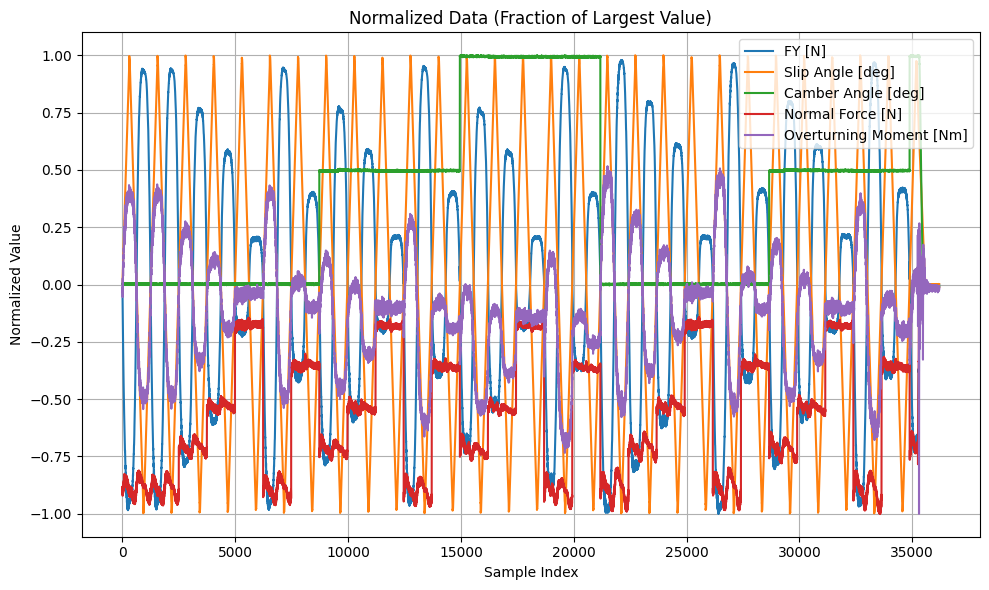

In [21]:
V = r2['V'].flatten()
SA = r2['SA'].flatten()
IA = r2['IA'].flatten()
FZ = r2['FZ'].flatten()
FY = r2['FY'].flatten()
MX = r2['MX'].flatten()

# Normalize all data as a fraction of their respective maximum absolute value
V_norm = V / np.max(np.abs(V)) if np.max(np.abs(V)) != 0 else V
SA_norm = SA / np.max(np.abs(SA)) if np.max(np.abs(SA)) != 0 else SA
IA_norm = IA / np.max(np.abs(IA)) if np.max(np.abs(IA)) != 0 else IA
FZ_norm = FZ / np.max(np.abs(FZ)) if np.max(np.abs(FZ)) != 0 else FZ
FY_norm = FY / np.max(np.abs(FY)) if np.max(np.abs(FY)) != 0 else FY
MX_norm = MX / np.max(np.abs(MX)) if np.max(np.abs(MX)) != 0 else MX

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(FY_norm, label='FY [N]')
ax.plot(SA_norm, label='Slip Angle [deg]')
ax.plot(IA_norm, label='Camber Angle [deg]')
ax.plot(FZ_norm, label='Normal Force [N]')
ax.plot(MX_norm, label='Overturning Moment [Nm]')

ax.set_title('Normalized Data (Fraction of Largest Value)')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Normalized Value')
ax.grid()
ax.legend()

fig.tight_layout()
plt.show()

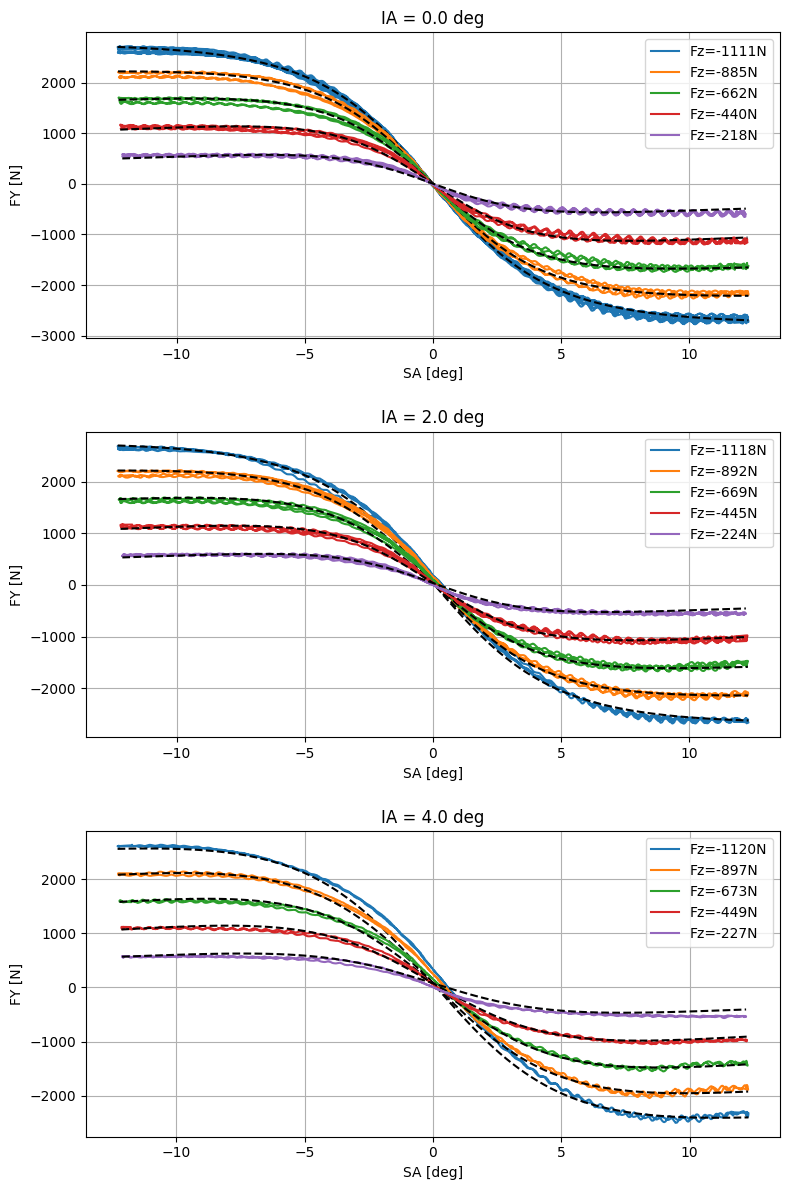

In [ ]:
import numpy as np


camber_steps = regroup_similar_steps(process_stepwise_data(IA, extr_data=[FZ, SA, FY]), rel_tol=0.05)

del camber_steps[1]#removes the second camber step because it was garbage data


fig, ax = plt.subplots(3,1, figsize=(8, 12))
ax = ax.flatten()
for i, c_step in enumerate(camber_steps):
    camber_avg, (ca, fz, sa, fy) = c_step

    #Fit data with simple pacejka lite 5 parameter model    
    xdata = ((np.radians(sa), fz))
    popt, pcov = curve_fit(lambda x, p0, p1, p2, p3, p4, p5: pacejka_lite_Fy(x, [p0, p1, p2, p3, p4, p5]), xdata, fy)

    fz_steps = regroup_similar_steps(process_stepwise_data(fz, extr_data = [sa, fy]))

    for step in fz_steps:
        fz_avg, (fz, sa, fy) = step
        ax[i].plot(sa, fy, label = f"Fz={fz_avg:.0f}N")
        
        # Plot fitted curve using matplotlib's plot
        sa_fit = np.linspace(np.min(sa), np.max(sa), 100)
        fy_fit = pacejka_lite_Fy ((np.radians(sa_fit), fz_avg), popt)
        ax[i].plot(sa_fit, fy_fit, '--', color = 'black')

    ax[i].set_title(f'IA = {camber_avg:.1f} deg')
    ax[i].set_xlabel('SA [deg]')
    ax[i].set_ylabel('FY [N]')
    ax[i].grid()
    ax[i].legend()


fig.tight_layout(h_pad=2)
plt.show()

### Peak force

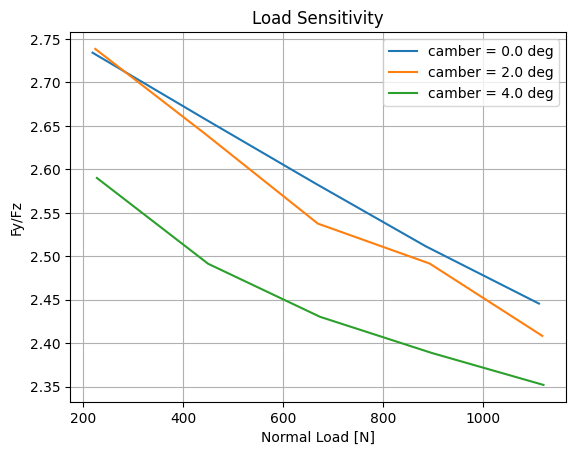

In [23]:
for c_step in camber_steps:
    camber_avg, (ca, fz, sa, fy) = c_step

    fz_steps = regroup_similar_steps(process_stepwise_data(fz, extr_data = [sa, fy]))

    load_sens_data = np.array([ [np.abs(fz_avg), fy[np.argmax(fy)]/np.abs(fz_avg)] for fz_avg, (fz, sa, fy) in fz_steps ]).T

    plt.plot(*load_sens_data, label = 'camber = {:.1f} deg'.format(camber_avg))



plt.title('Load Sensitivity')
plt.xlabel('Normal Load [N]')
plt.ylabel('Fy/Fz')
plt.legend()
plt.grid()
plt.show()